# COVID-19 Forecasting: Logistic Curve Fitting, B-Spline Regression, SIR

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import integrate, optimize, interpolate as si

from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder

import glob


# Plot configurations
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
sns.set_style("darkgrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)

In [2]:
# Path to input csvs
DATA_DIR = "csse_covid_19_daily_reports/"

# Dates to model
MIN_DATE = '2020-03-01'
MAX_DATE = '2020-04-28'
DATE_LIST = pd.date_range(MIN_DATE, MAX_DATE).strftime('%Y-%m-%d').tolist()

# Individual countries to model
MODEL_COUNTRIES = ["US", "Italy", "Spain", "Germany", "France"]

In [3]:
def build_aggregate_df():

    df = None  # Placeholder dataframe

    for fn in glob.glob(DATA_DIR + "*.csv"):
        daily_df = pd.read_csv(fn)
        daily_df["Date"] = fn.split("/")[-1].split(".csv")[0]
        daily_df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Deaths": "Fatalities",
            "Confirmed": "ConfirmedCases"
        }, inplace=True)
        if df is None:
            df = daily_df
        else:
            df = df.append(daily_df, ignore_index=True)

    # Type conversions
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)
    
    # Apply filters
    df = df[df.Date.isin(DATE_LIST)]
    
    # Handle nulls
    df["Province_State"].fillna("Other", inplace=True)
    
    # Column Selection
    cols = ["Date", "Country_Region",  "ConfirmedCases"]
    
    # Aggregate at date, country grain
    df = df[cols].groupby(by=["Date", "Country_Region"]).sum()
    df = df.reset_index()
    df = df[cols]
    
    # Encode date column as an integer
    le = LabelEncoder()
    df['DayNum'] = le.fit_transform(df.Date)
    

    print("Num Rows:", df.shape[0])
    print("Total Dates:", df["Date"].unique().shape[0])
    print("Min Date:", df["Date"].min())
    print("Max Date:", df["Date"].max())
    
    return df

all_data = build_aggregate_df()

all_data.head()

Num Rows: 9477
Total Dates: 59
Min Date: 2020-03-01 00:00:00
Max Date: 2020-04-28 00:00:00


,Date,Country_Region,ConfirmedCases,DayNum
0,2020-03-01,Afghanistan,1.0,0
1,2020-03-01,Algeria,1.0,0
2,2020-03-01,Armenia,1.0,0
3,2020-03-01,Australia,27.0,0
4,2020-03-01,Austria,14.0,0


## Logistic Curve Fitting By Country

In [4]:
def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))


def fit_logistic(x_data, y_data, x_test):
    """Fit logstic curve"""
    popt, pcov = optimize.curve_fit(log_curve, x_data, y_data, bounds=([0,0,0], np.inf), maxfev=1000)
    estimated_k, estimated_x_0, ymax = popt
    y_fitted = log_curve(x_test, estimated_k, estimated_x_0, ymax)
    
    return y_fitted

    
def plot_logistic(df, country_name, extrapolate=5, holdout=5):
    country_df = df.loc[df['Country_Region']==country_name, ["DayNum", "ConfirmedCases"]]

    # Limit to day_start through most recent
    day_start = LOGISTIC_START_DAYS.get(country_name, 0)
    country_df = country_df[day_start:]
    
    X_train = list(range(country_df.DayNum.min(), country_df.DayNum.max() + 1))
    y_train = country_df.ConfirmedCases
    
    
    # Full data to project on (seen data + extrapolation)
    X_test = X_train + list(range(X_train[-1] + 1, X_train[-1] + extrapolate))
    
    preds = fit_logistic(X_train[:-holdout], y_train[:-holdout], X_test)
    
    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(111)
    ax.plot(X_test, preds, '--', label='fitted')
    ax.plot(X_train, y_train, label='Confirmed Data')
    
    ax.set_ylabel("Confirmed Cases")
    ax.set_xlabel("Day Number")
    
    ax.axvline(X_train[-1]-holdout, linewidth=2, ls = ':', color='black', alpha=0.5)
    ax.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')

    plt.suptitle((f"Confirmed Cases Logistic Curve for {country_name}"))

    plt.show()

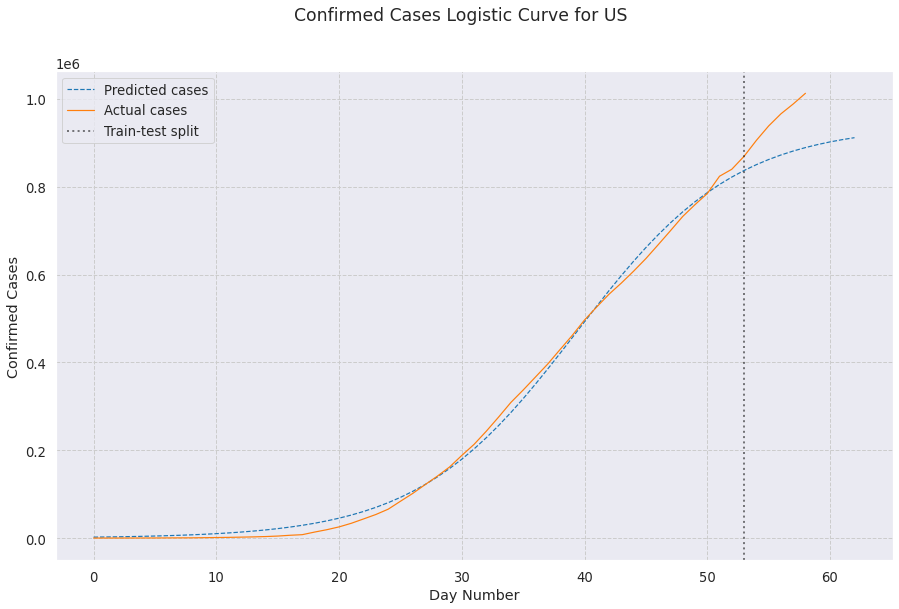

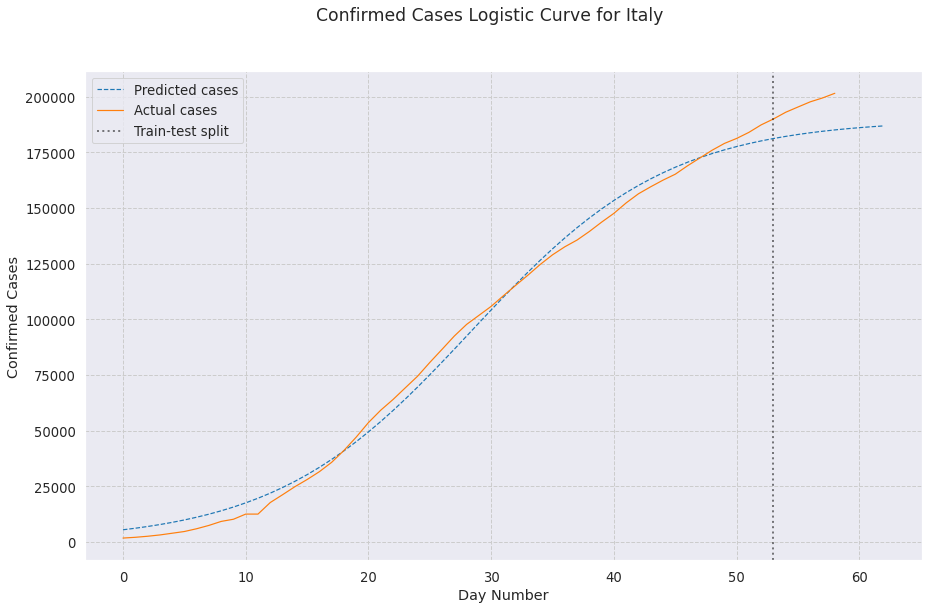

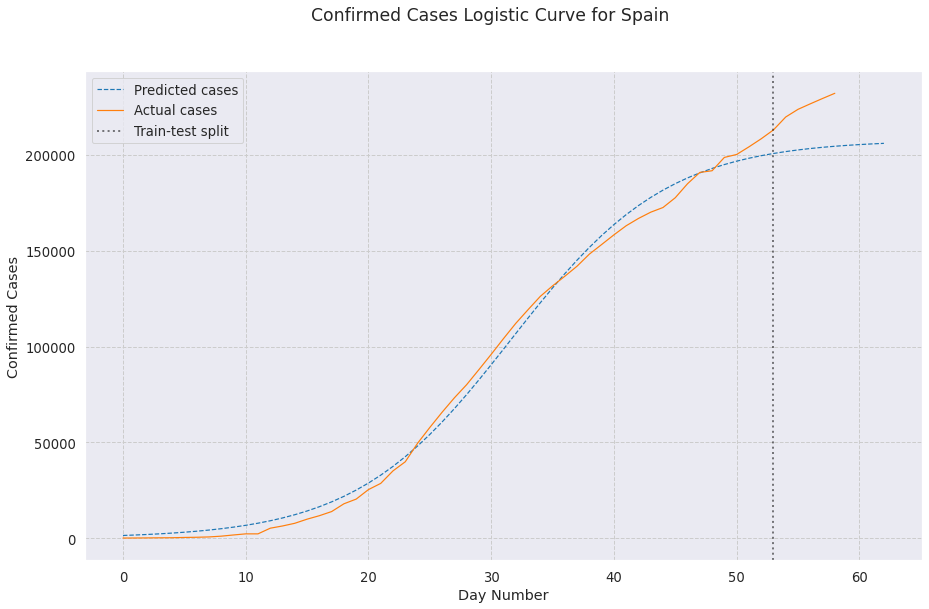

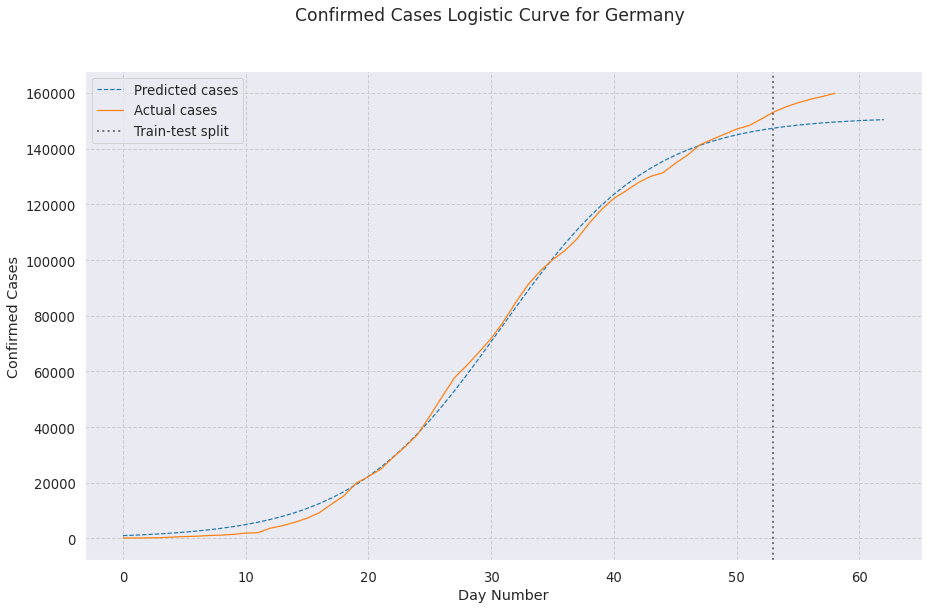

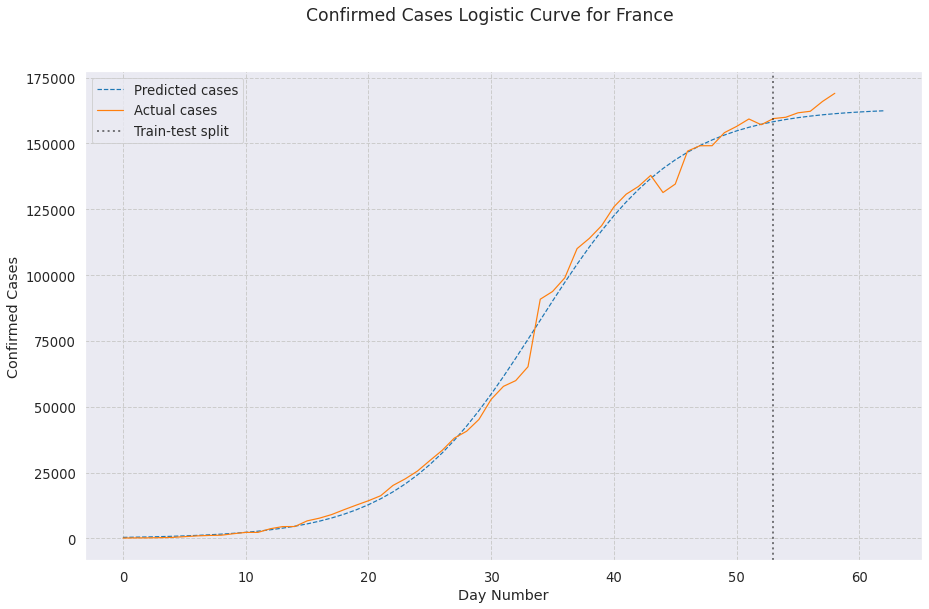

In [5]:
#### Starting oubteak day number for logistic curves
LOGISTIC_START_DAYS = {
    "US": 0,
    "Italy": 0,
    "Spain": 0,
    "Germany": 0,
    "France": 0
}

for country_name in MODEL_COUNTRIES:
    plot_logistic(all_data, country_name, extrapolate=5, holdout=5)

## Linear Regression By Country

In [6]:
def preprocess_for_bspline(df):   
    data = df.copy()

    # Filter selected features
    features = [
        'DayNum',
        'ConfirmedCases',
    ]

    data = data[features]

    # Apply log transformation to ConfirmedCases
    data['ConfirmedCases'] = data['ConfirmedCases'].astype('float64')
    data['ConfirmedCases'] = data['ConfirmedCases'].apply(lambda x: np.log1p(x))

    # Replace infinites
    data.replace([np.inf, -np.inf], 0, inplace=True)
    
    return data


def split_data(data, holdout):
    """Split data into train and test sets"""
    
    # Test set
    x_test = data.drop(['ConfirmedCases'], axis=1)
    
    # Train on only date through shift
    data = data[:-holdout]
    
    # Train set
    x_train = data.drop(['ConfirmedCases'], axis=1)
    y_train = data['ConfirmedCases']
    
    return x_train, y_train, x_test


class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features
    
    
def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines


def bspline_regressor(X_train, Y_train, X_test, degree=1, n_knots=3):
    """B-Spline Linear regression model"""
    
    # Build b-spline model
    knots = np.linspace(0, len(DATE_LIST), n_knots)
    bspline_features = BSplineFeatures(knots, degree=degree, periodic=False)
    regr = make_pipeline(bspline_features, linear_model.LinearRegression())

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return y_pred

In [7]:
def plot_regression(df, country_name, holdout=5, degree=1, n_knots=3):
    
    # Filter for target country and preprocess
    country_df = df[df['Country_Region']==country_name]
    country_df = preprocess_for_bspline(country_df)
    
    # Limit to day_start through most recent
    day_start = REGRESSION_START_DAYS.get(country_name, 0)
    country_df = country_df[day_start:]
    
    # Split into train and test sets
    X_train, y_train, X_test = split_data(country_df, holdout)
    
    # Get predictions
    predicted_data = X_test.copy()
    predicted_data['Target'] = bspline_regressor(X_train, y_train, X_test, degree=degree, n_knots=n_knots)

    # X-axis data for plot
    date_list = list(range(country_df.DayNum.min(), country_df.DayNum.max() + 1))
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(date_list, np.expm1(predicted_data.Target), '--')
    ax1.plot(date_list, np.expm1(country_df.ConfirmedCases))
    ax1.axvline(max(date_list)-holdout, linewidth=2, ls = ':', color='black', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_ylabel("Confirmed Cases")
    ax1.set_xlabel("Day Number")

    ax2.plot(date_list, predicted_data.Target, '--')
    ax2.plot(date_list, country_df.ConfirmedCases)
    ax2.axvline(max(date_list)-holdout, linewidth=2, ls = ':', color='black', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_ylabel("Log Confirmed Cases")
    ax2.set_xlabel("Day Number")

    plt.suptitle((f"Confirmed Cases B-Spline Regression for {country_name}, {degree} Degrees"))

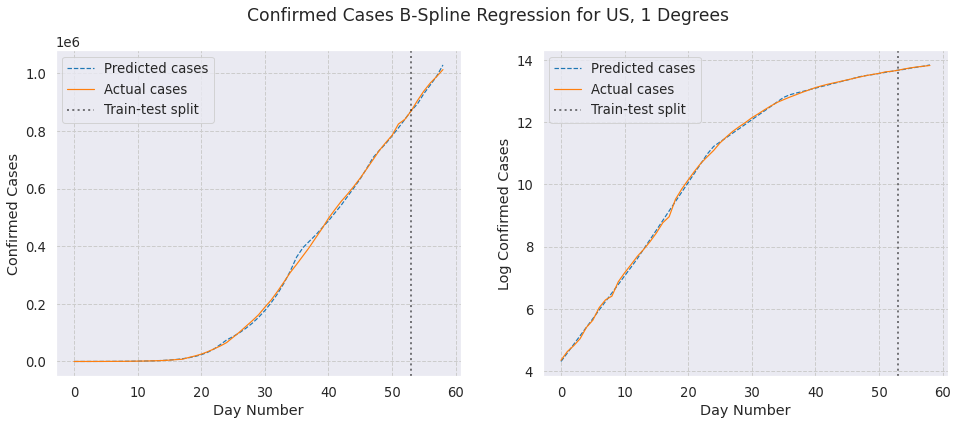

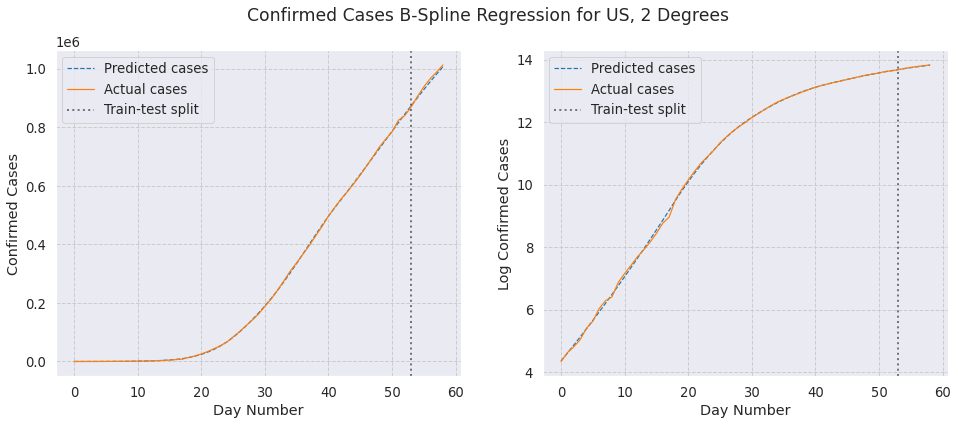

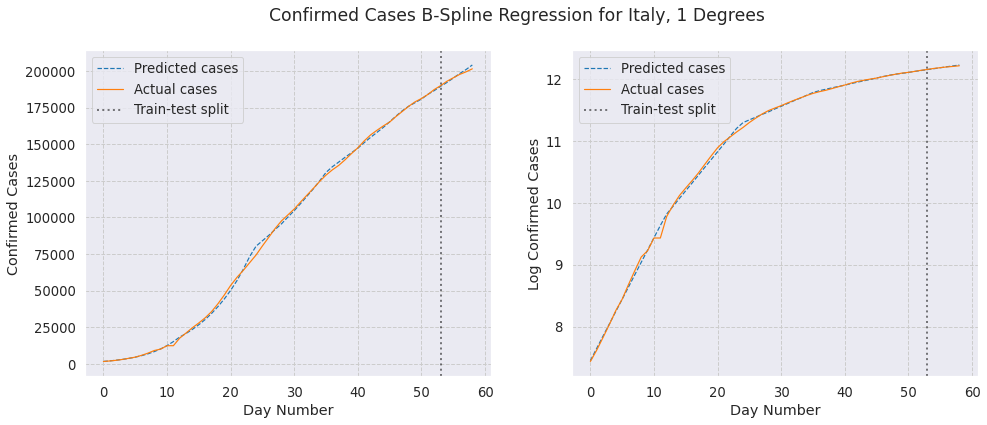

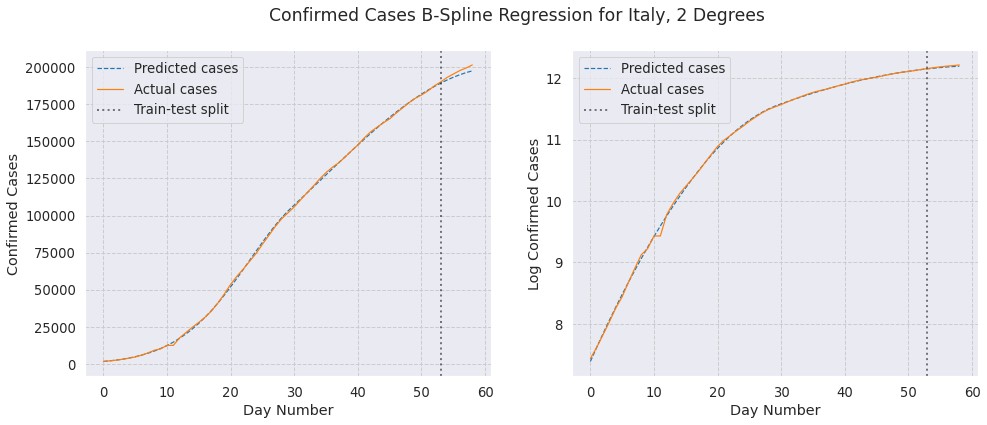

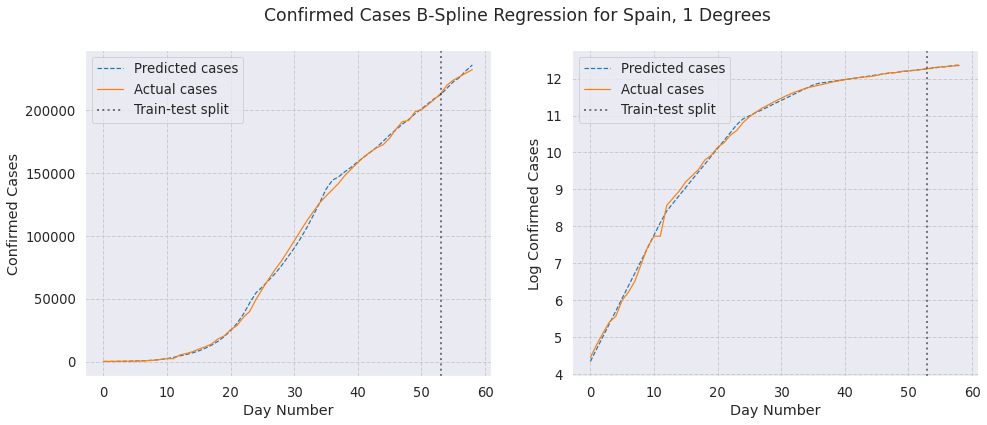

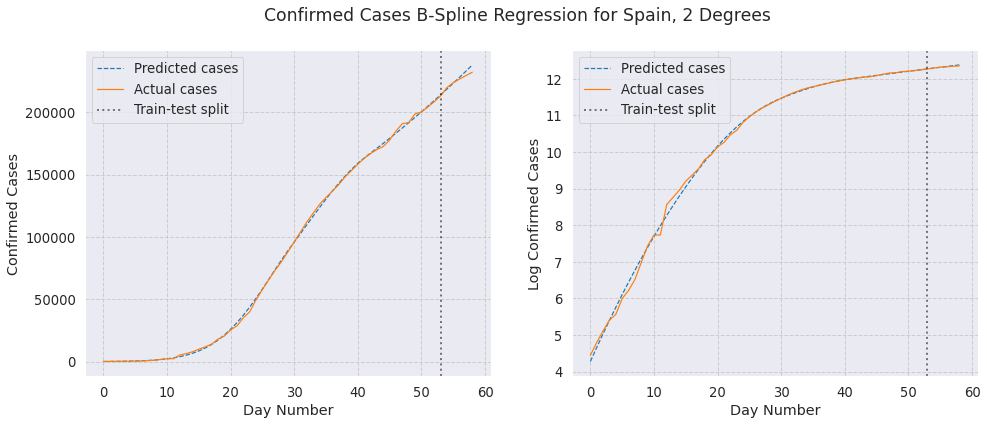

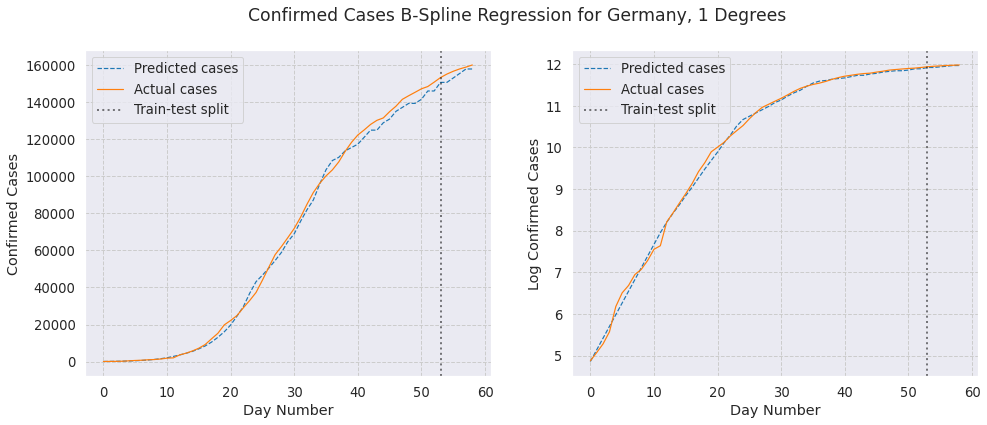

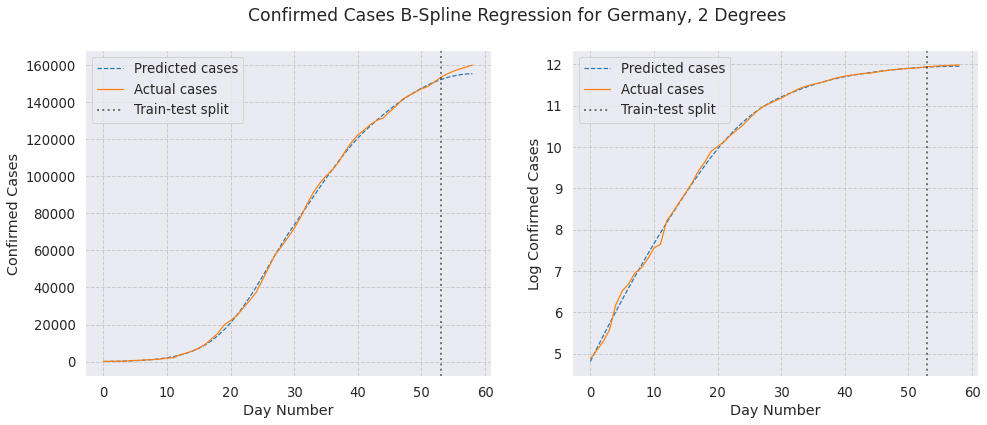

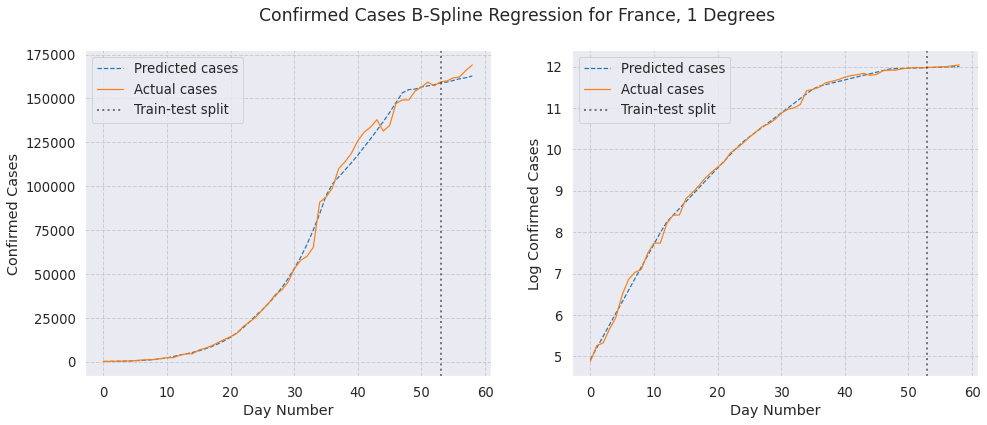

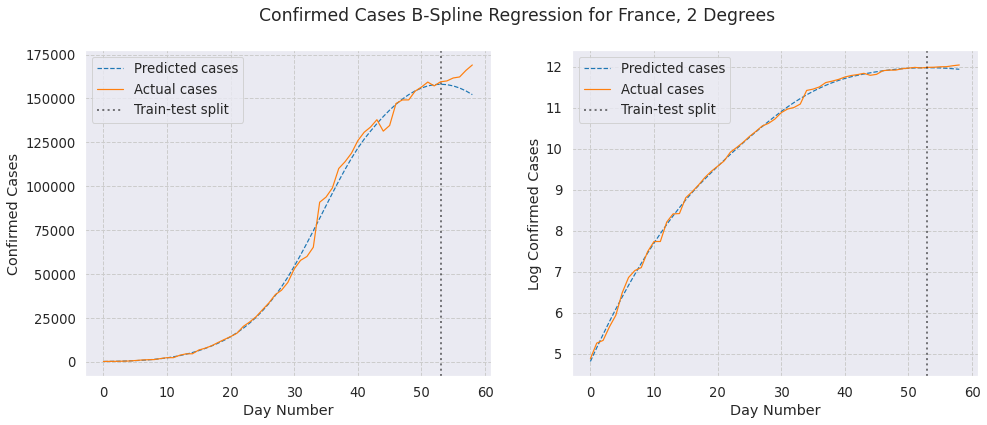

In [8]:
# Starting oubteak day number for regression
REGRESSION_START_DAYS = {
    "US": 0,
    "Spain": 0,
    "Italy": 0,
    "Germany": 0,
    "France": 0
}

degrees_to_plot = [1, 2]

for country_name in MODEL_COUNTRIES:
    for degree in degrees_to_plot:
        plot_regression(all_data, country_name, holdout=5, degree=degree, n_knots=6)

## SIR Model By Country

In [9]:
def fa(N, a, b, beta):
    """Susceptible equation"""
    fa = -beta*a*b
    return fa


def fb(N, a, b, beta, gamma):
    """Infected equation"""
    fb = beta*a*b - gamma*b
    return fb


def fc(N, b, gamma):
    """Recovered/deceased equation"""
    fc = gamma*b
    return fc


def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    """
    Runge-Kutta method of 4rth order for 3 dimensions 
    (susceptible a, infected b and recovered r)
    """
    
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    
    return a, b, c

In [10]:
populations = {
    "US": 328200000,
    "Italy": 60480000,
    "Spain": 46940000,
    "Germany": 83020000,
    "France": 66990000
}

In [11]:
def plot_sir(df, country_name):
    population = populations[country_name]

    country_df = (
        df.loc[df['Country_Region']==country_name]
        .ConfirmedCases.diff()
        .fillna(0)
        .to_frame()
    )

    # Limit plot to more recent data
    day_start = SIR_START_DAYS.get(country_name, 0)
    country_df = country_df[day_start:]
    country_df['day_count'] = list(range(1, len(country_df)+1))

    y_data = country_df.ConfirmedCases
    x_data = country_df.day_count
    y_data = np.array(y_data, dtype=float)
    x_data = np.array(x_data, dtype=float)

    N = population
    inf0 = y_data[0]
    sus0 = N - inf0
    rec0 = 0.0
    
    
    def sir_model(y, x, beta, gamma):
        sus = -beta * y[0] * y[1] / N
        rec = gamma * y[1]
        inf = -(sus + rec)
        return sus, inf, rec
    
    
    def fit_odeint(x, beta, gamma):
        return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

    popt, pcov = optimize.curve_fit(fit_odeint, x_data, y_data)
    fitted = fit_odeint(x_data, *popt)

    plt.figure(figsize=(15,9))
    plt.plot(x_data, y_data, 'o')
    plt.plot(x_data, fitted)
    plt.title(f"Fit of SIR model for {country_name} infected cases")
    plt.ylabel("Cases")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1]) 

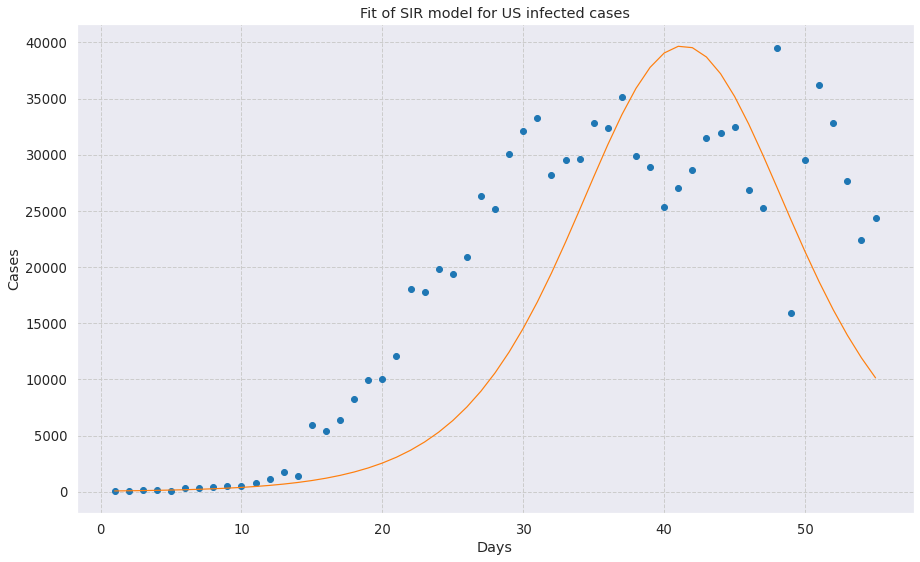

Optimal parameters: beta = 12.4064482383037  and gamma =  12.214158823155522


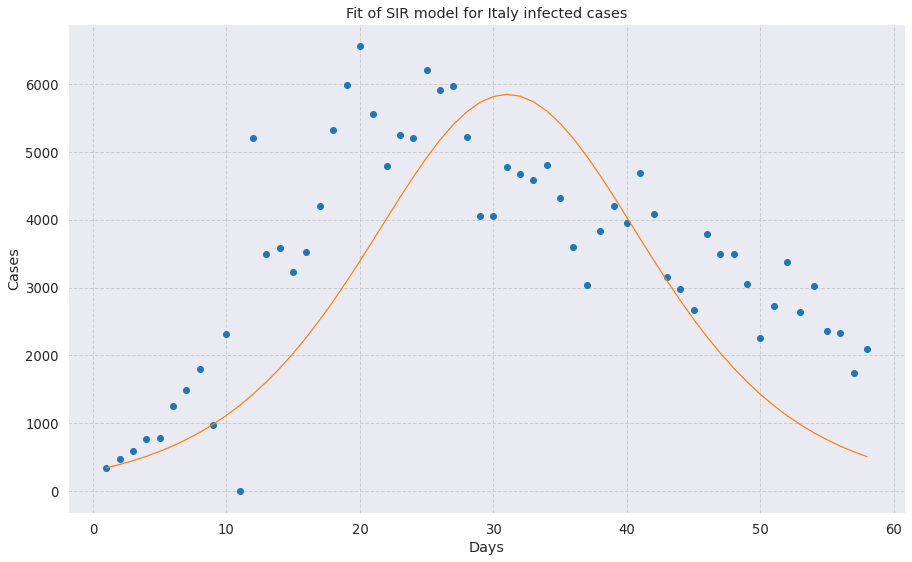

Optimal parameters: beta = -10.00544754044988  and gamma =  -10.140702821685373


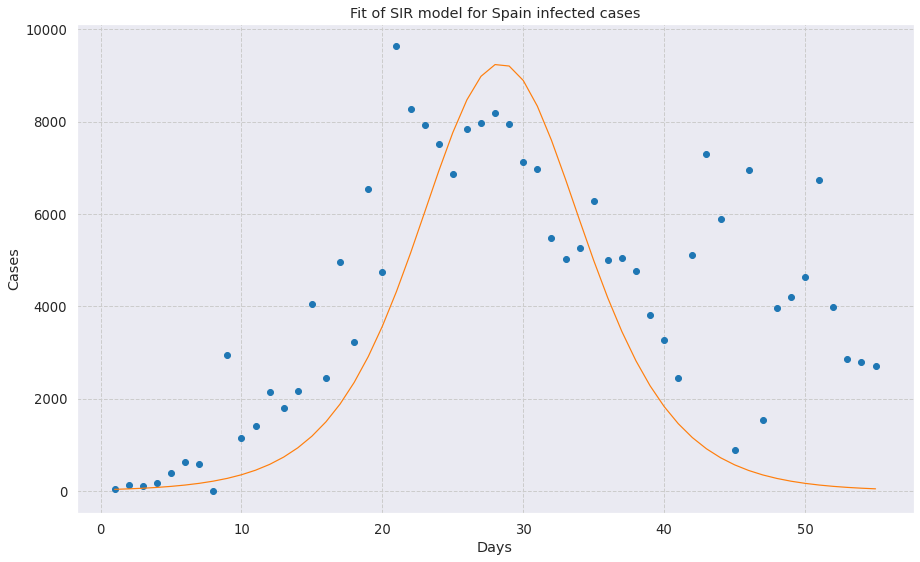

Optimal parameters: beta = 12.755244328603984  and gamma =  12.503265572647758


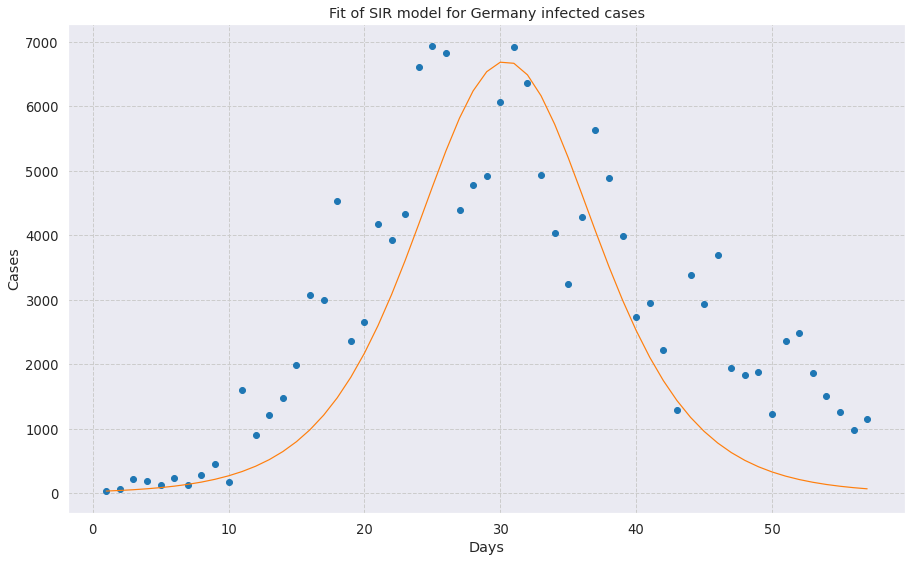

Optimal parameters: beta = 17.677441006080233  and gamma =  17.45394891794759


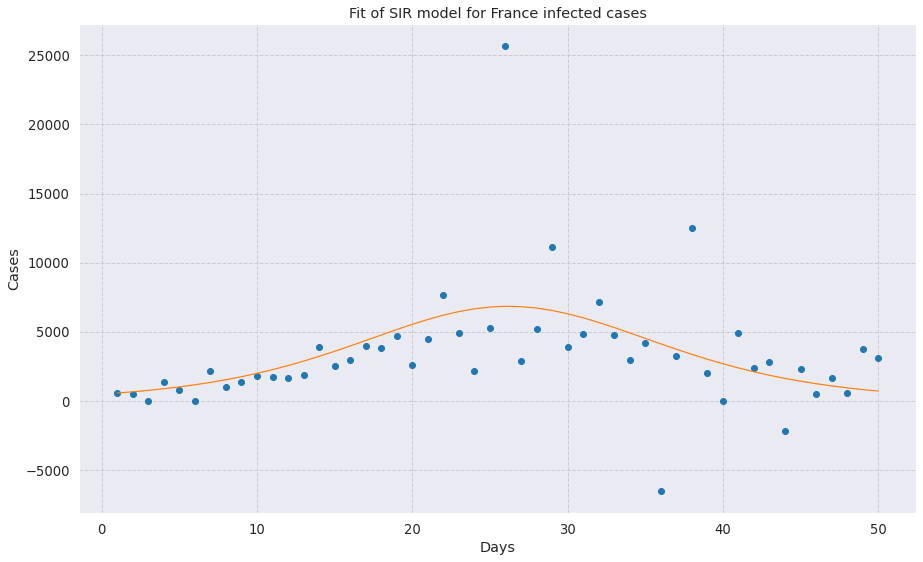

Optimal parameters: beta = 10.649104881269507  and gamma =  10.503611761252769


In [12]:
##### Starting oubteak day number for SIR modeling
SIR_START_DAYS = {
    "US": 4,
    "Italy": 1,
    "Spain": 4,
    "Germany": 2,
    "France": 9
}

for country_name in MODEL_COUNTRIES:
    plot_sir(all_data, country_name)